# Data import 


In [1]:
import pandas as pd
# import of data
student_data_unpr = pd.read_excel("../data/subset_studium_german.xlsx")
student_data_unpr = student_data_unpr.drop("Unnamed: 0", axis=1)
student_data_unpr = student_data_unpr.drop("Studium_Comment", axis=1)

#Reduction to 300 entries
student_data_unpr = student_data_unpr.drop(student_data_unpr.index[300:], axis=0)

#Creation of a copy and reduction to column "Studium"
student_data = student_data_unpr
student_data = student_data.drop("Studium_Label", axis=1)


# OpenAI GPT3.5 application

In [2]:
from openai import OpenAI
client = OpenAI()

In [3]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. Only response with either positive, neutral or negative"}

results=[]
results_df = []

# Sending labeling requests to GPT
for index, eintrag in student_data.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            temperature=0,
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "sentimentPrediction": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)




# Evaluation

In [4]:
#Merge target labels with predicted labels
results_df = results_df.drop("index", axis=1)


student_data = pd.concat([student_data_unpr, results_df], axis=1)
student_data = student_data[student_data["Studium_Label"].notnull()]


#Convertion of all values into strings
for x in student_data:
    student_data[x] = student_data[x].astype(str)


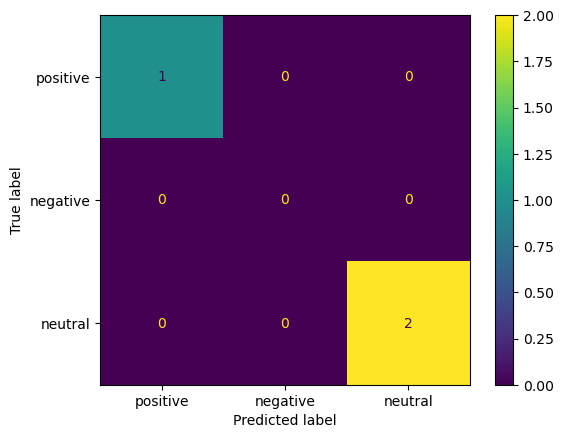

1.0


ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data['Studium_Label'],
    student_data['sentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))